# SVM

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, matthews_corrcoef, log_loss)
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score


In [4]:
current_dir = Path.cwd()
data_dir = current_dir.parent / 'data' / 'processed' 
file_path = data_dir / 'Obesity_data_processed.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

In [5]:
y = df['Obese_or_not']

X = df.drop('Obese_or_not', axis=1)

In [6]:
ordinal_features = ['Province', 'Sex', 'Marital_status', 'Age', 'Working_12_months', 'Education_level', 
                    'Perceived_life_stress', 'Smoker', 'Drinker_12_months', 'Physical_activity', 
                    'Has_regular_healthcare_provider', 'Immigrant', 'Cultural_racial_background', 
                    'Food_security', 'Personal_income']

feature_orders = {
    'Province': ['NB', 'BC', 'ON', 'QUE', 'MN', 'AB', 'NL', 'PEI', 'NS', 'SASK'],
    "Sex": ["Female", "Male"],
    'Marital_status': ['Single', 'Common-law', 'Widow/Divorced/Sep', 'Married'],
    'Age': ['25 - 29', '20 - 24', '55 - 59', '35 - 39', '60 - 64', '40 - 44', '30 - 34', '50 - 54', '45 - 49'],
    'Working_12_months': ['Yes', 'No'],
    'Education_level': ['Less than secondary school graduation', 'Secondary school graduation only', 'Post-secondary diploma or uni degree'],
    'Perceived_life_stress': ['Not at all stressful', 'Not very stressful', 'A bit stressful', 'Quite a bit stressful', 'Extremely stressful'],
    'Smoker': ['Not at all', 'Occasionally', 'Daily'],
    'Drinker_12_months': ['Did not drink in the last 12 months', 'Occasional drinker', 'Regular drinker'],
    'Physical_activity': ["At/above rec'd level from CPAG", "Below rec'd level from CPAG", 'No physical activity'],
    'Has_regular_healthcare_provider': ['Yes', 'No'],
    'Immigrant': ['Immigrant', 'Canadian born'],
    'Cultural_racial_background': ['White', 'Non-white (other visible minority)', 'Aboriginal'],
    'Food_security': ['Food secure', 'Moderately food insecure', 'Severely food insecure'],
    'Personal_income': ['No income or income loss', 'Less than $20,000', '$20,000 - $39,999', '$40,000 - $59,999', '$60,000 - $79,999', '$80,000 or more']
}


X_ordinal = pd.DataFrame(df[ordinal_features])

categories_order = [feature_orders[feature] for feature in ordinal_features]

encoder = OrdinalEncoder(categories=categories_order)
X_ordinal_encoded = encoder.fit_transform(X_ordinal)
X_ordinal_encoded_df = pd.DataFrame(X_ordinal_encoded, columns=[f'{feat}_encoded' for feat in ordinal_features])

## SVM Linear Model

In [7]:
# Creates pipeline to standardize data then applies SVM and fits to model:

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

y_encoded = y.map({'Not obese': 0, 'Obese': 1}).astype(int)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X_ordinal_encoded_df, y_encoded, test_size=0.2, random_state=42)

svm_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42))
svm_clf.fit(X_train, y_train_encoded)

c:\Users\dusti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

In [21]:
predictions = svm_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test_encoded, predictions))
print(classification_report(y_test_encoded, predictions))

Accuracy: 0.6875410374261326
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      8356
           1       0.55      0.03      0.06      3828

    accuracy                           0.69     12184
   macro avg       0.62      0.51      0.43     12184
weighted avg       0.65      0.69      0.58     12184



### Graphics

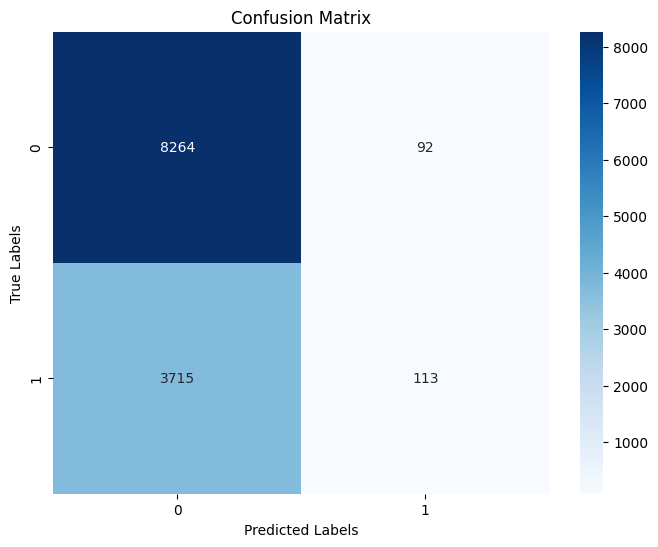

In [22]:
cm = confusion_matrix(y_test_encoded, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

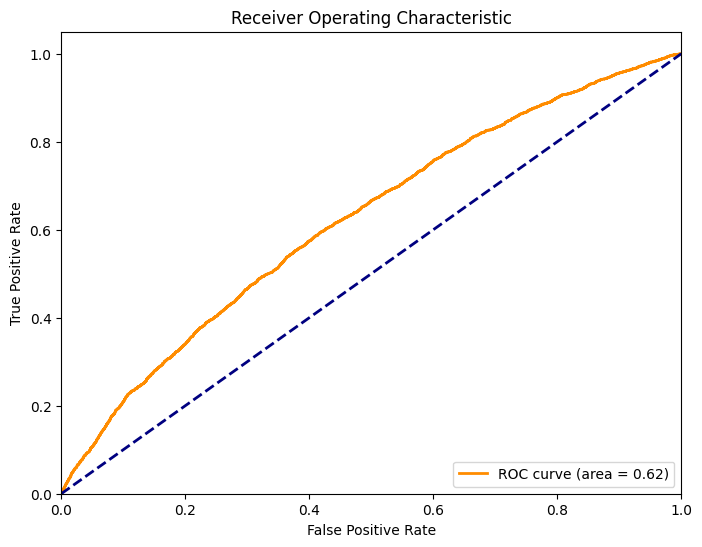

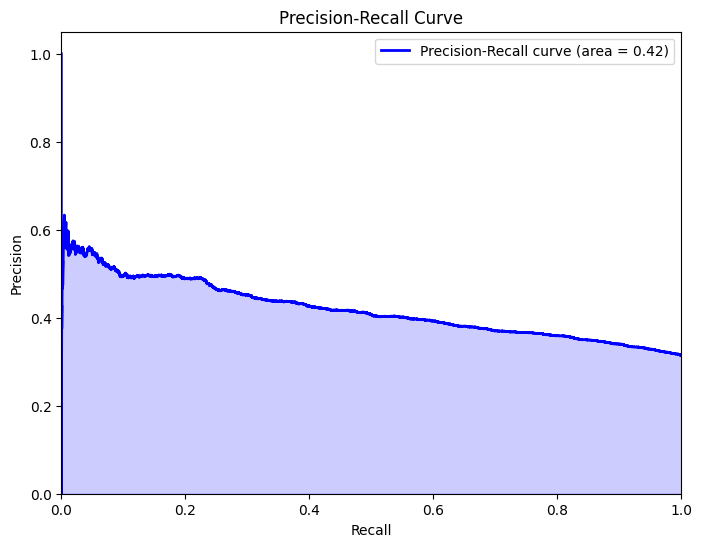

In [23]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test_encoded, svm_clf.decision_function(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_encoded, svm_clf.decision_function(X_test))
average_precision = average_precision_score(y_test_encoded, svm_clf.decision_function(X_test))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

## Metrics:

Accuracy
This first Model achieves an accuracy of 68.75%, which indicates that it correctly predicts the obesity status for approximately 69 out of every 100 instances in the test set.

Precision, Recall, and F1-Score:
For Class 0 (Not Obese): The model has high precision (69%) and very high recall (99%), leading to a high F1-score (81%). The model is very effective at identifying the 'Not Obese' class.
For Class 1 (Obese): The precision is lower (55%), and the recall is extremely low (3%), resulting in a very low F1-score (6%). This indicates that while when the model predicts an instance as 'Obese', it is correct more than half the time, it hardly ever predicts 'Obese', missing out on nearly all true 'Obese' instances.

ROC:

ROC curve area of 0.62 suggests that the model has a modest ability to distinguish between the 'Obese' and 'Not Obese' classes. 

Precision-Recall Curve:

The area under the precision-recall curve of 0.42 for the 'Obese' class suggests moderate performance. In the context of an imbalanced dataset, where positive instances ('Obese') are less frequent, this metric is crucial. The relatively low value indicates that the model struggles to identify positive instances without many false positives.

Interpretation:
The model performs well in identifying 'Not Obese' individuals but struggles significantly with correctly identifying 'Obese', as shown by the low recall for class 1. 

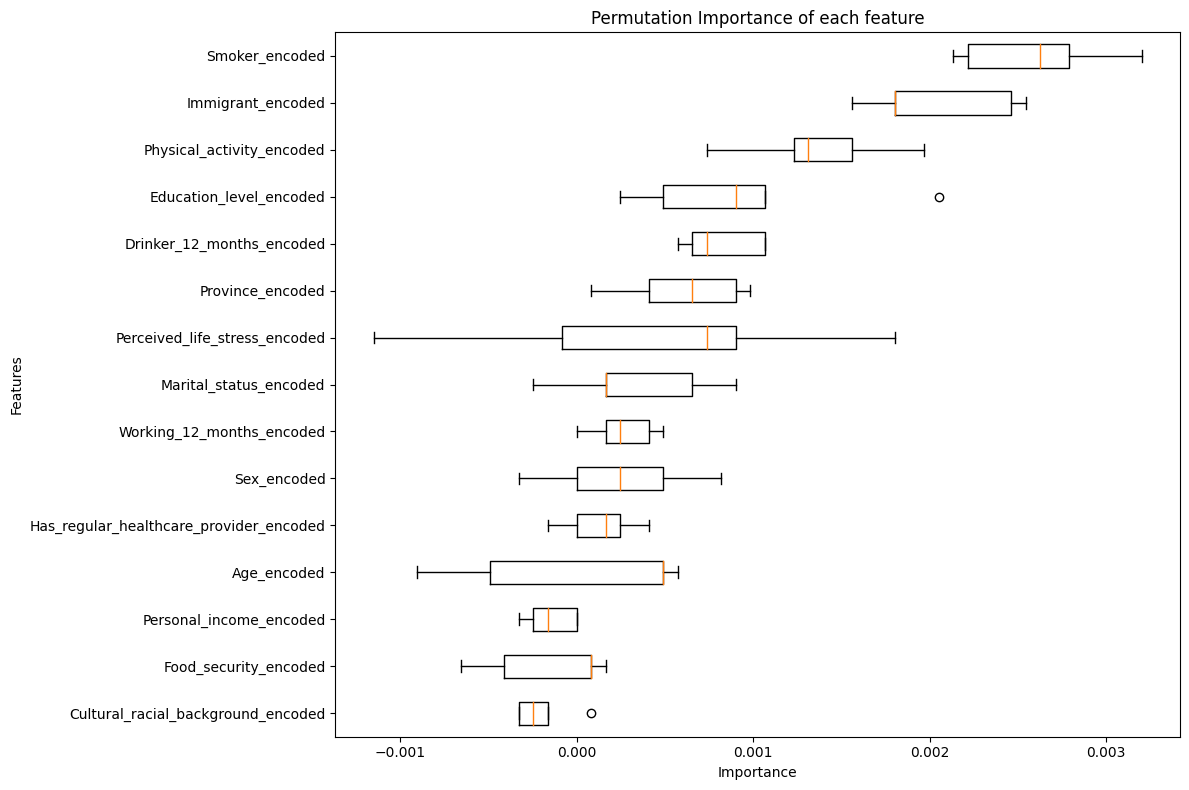

In [8]:
# Feature importance

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

result = permutation_importance(svm_clf, X_test, y_test_encoded, n_repeats=5, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_ordinal_encoded_df.columns[sorted_idx])
plt.title("Permutation Importance of each feature")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## RBF Kernel with RandomizedSearchCV

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('svc', SVC(kernel='rbf', random_state=42)) ])

param_distributions = {
    'svc__C': reciprocal(0.1, 20),  
    'svc__gamma': expon(scale=1.0)}  


random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=50, cv=3, scoring='accuracy', verbose=2, random_state=42, n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(X_ordinal_encoded_df, y_encoded, test_size=0.2, random_state=42)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017F82C07790>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017F82C78250>},
                   random_state=42, scoring='accuracy', verbose=2)

In [25]:
best_model = random_search.best_estimator_

predictions = best_model.predict(X_test)

print("Best parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Best parameters: {'svc__C': 0.5022563311994769, 'svc__gamma': 0.10277731500250624}
Accuracy: 0.6901674326986211
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      8356
           1       0.59      0.04      0.08      3828

    accuracy                           0.69     12184
   macro avg       0.64      0.51      0.45     12184
weighted avg       0.66      0.69      0.58     12184



## Grahics

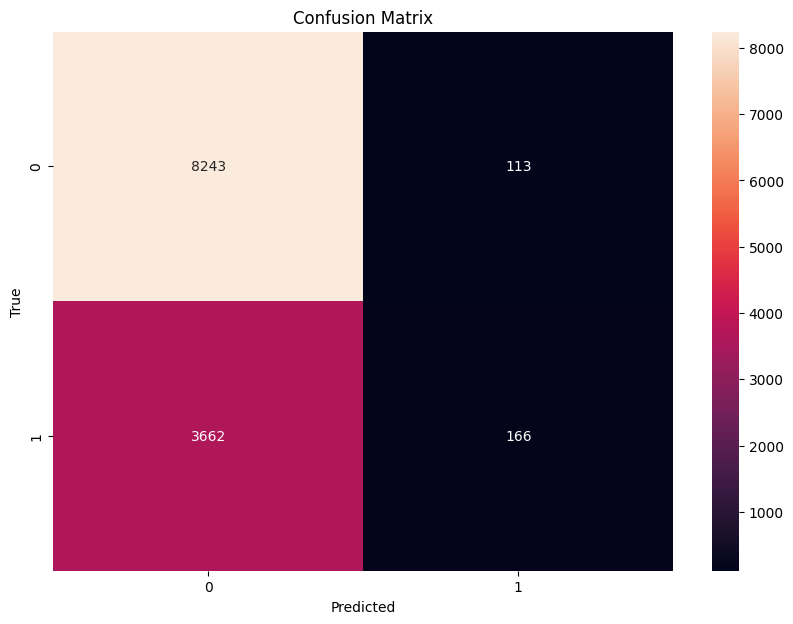

In [26]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

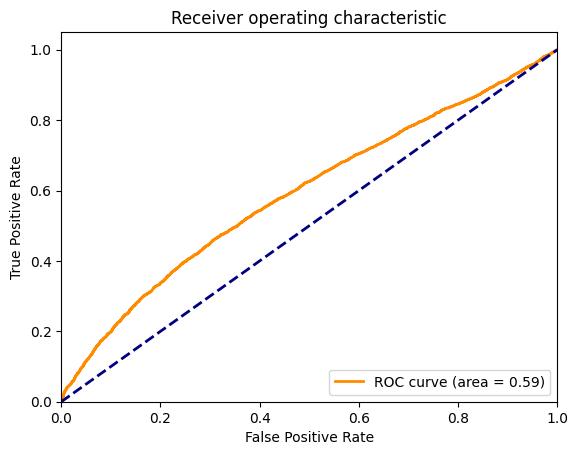

In [27]:
# ROC

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

fpr, tpr, _ = roc_curve(y_test, best_model.decision_function(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


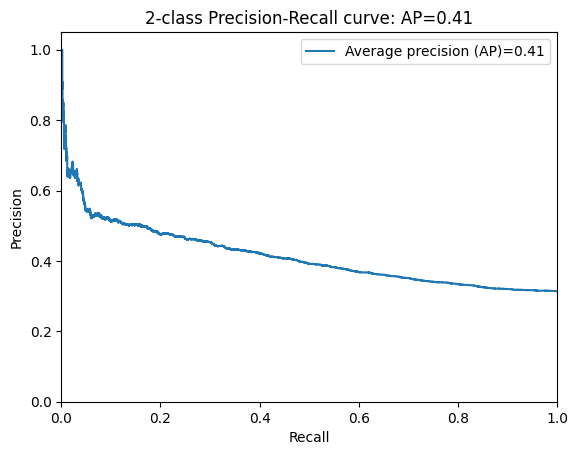

In [28]:
# Precision-Recall

from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, best_model.decision_function(X_test))
average_precision = average_precision_score(y_test, best_model.decision_function(X_test))

plt.figure()
plt.step(recall, precision, where='post', label='Average precision (AP)={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="best")
plt.show()

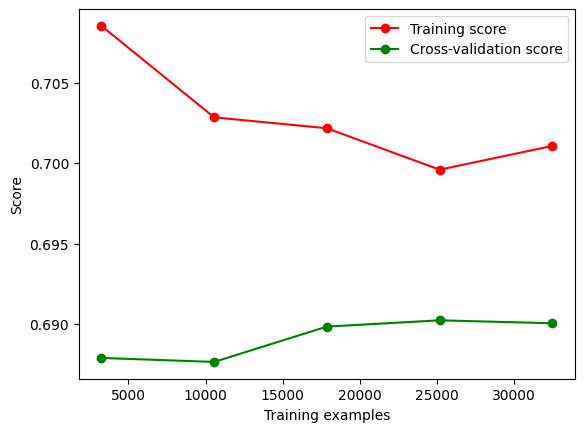

In [29]:
#Learning curve 
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

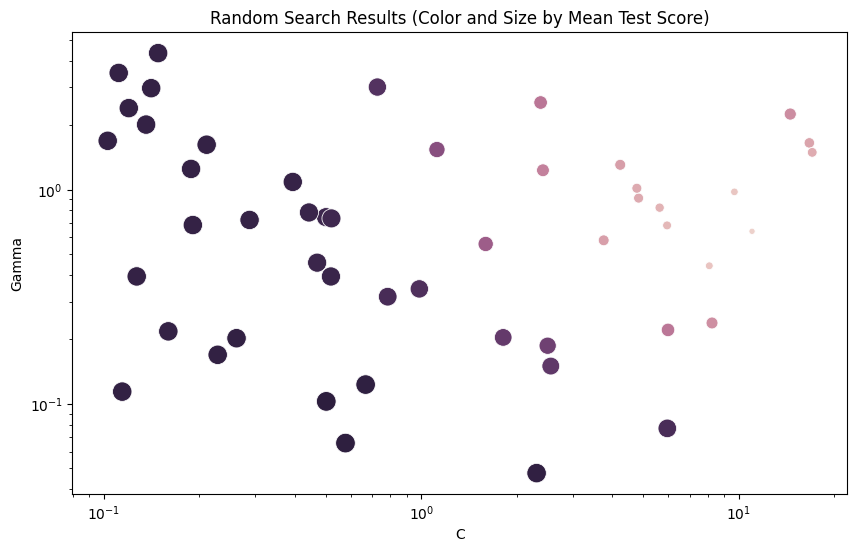

In [30]:
# Gridsearch Heatmap

results = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(10,6))
sns.scatterplot(x="param_svc__C", y="param_svc__gamma", size="mean_test_score", hue="mean_test_score", data=results, legend=False, sizes=(20, 200))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.title("Random Search Results (Color and Size by Mean Test Score)")
plt.show()

## Metrics: 

Accuracy:
The overall accuracy of the model is 69.02%, meaning the model correctly predicts whether a subject is obese or not about 69% of the time on the test data.

Precision, Recall, and F1-Score:
For the non-obese class (0), the precision is high (0.69), indicating that when the model predicts a subject is not obese, it is correct about 69% of the time. The recall is very high (0.99), meaning the model identifies 99% of all non-obese cases correctly. However, these numbers result in a high F1-score (0.81), showing a good balance between precision and recall for this class.

ROC Curve Area and Average Precision:
The ROC curve area (AUC) of 0.59 suggests that the model has a limited ability to distinguish between the obese and non-obese classes. AUC values range from 0.5 (no discrimination) to 1.0 (perfect discrimination), so 0.59 indicates only slightly better performance than random guessing.
The average precision of 0.41 further underscores the model's limited effectiveness, especially in accurately identifying true positive cases for the obese class, given the low recall.

Summary:
The model shows a decent ability to predict non-obese individuals but struggles significantly with accurately identifying obese individuals, as evidenced by the low recall and F1-score for the obese class. 

# Obesity rates by country

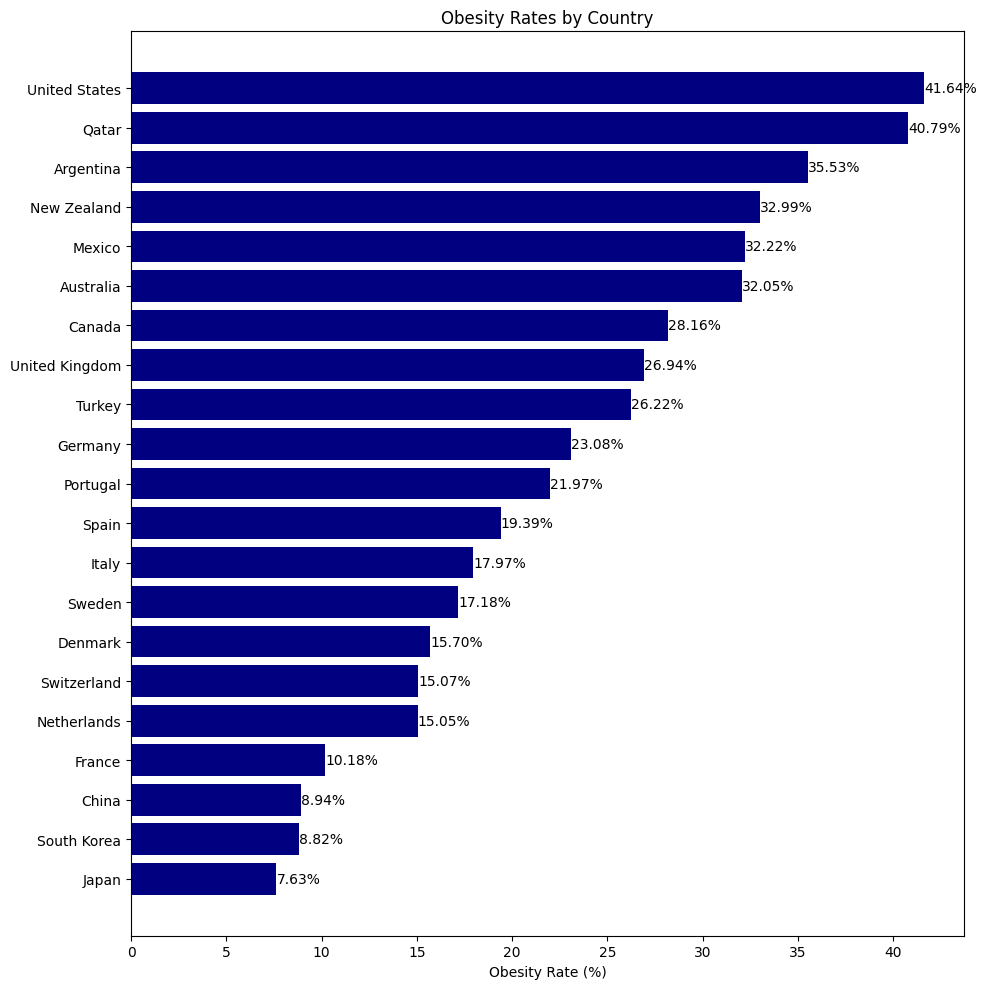

In [13]:
countries = [
    "United States", "Qatar", "Argentina", "New Zealand", "Mexico",
    "Canada", "United Kingdom", "Turkey", "Italy", "Spain",
    "Switzerland", "Netherlands", "France", "China", "South Korea",
    "Japan", "Australia", "Sweden", "Denmark", "Portugal", "Germany"]

obesity_rates = [
    41.64, 40.79, 35.53, 32.99, 32.22,
    28.16, 26.94, 26.22, 17.97, 19.39,
    15.07, 15.05, 10.18, 8.94, 8.82,
    7.63, 32.05, 17.18, 15.70, 21.97, 23.08]


sorted_indices = sorted(range(len(obesity_rates)), key=lambda i: obesity_rates[i], reverse=True)
sorted_countries = [countries[i] for i in sorted_indices]
sorted_obesity_rates = [obesity_rates[i] for i in sorted_indices]


plt.figure(figsize=(10, 10))  
bars = plt.barh(sorted_countries, sorted_obesity_rates, color='navy')


for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}%',
             va='center', ha='left')

plt.xlabel('Obesity Rate (%)')
plt.title('Obesity Rates by Country')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


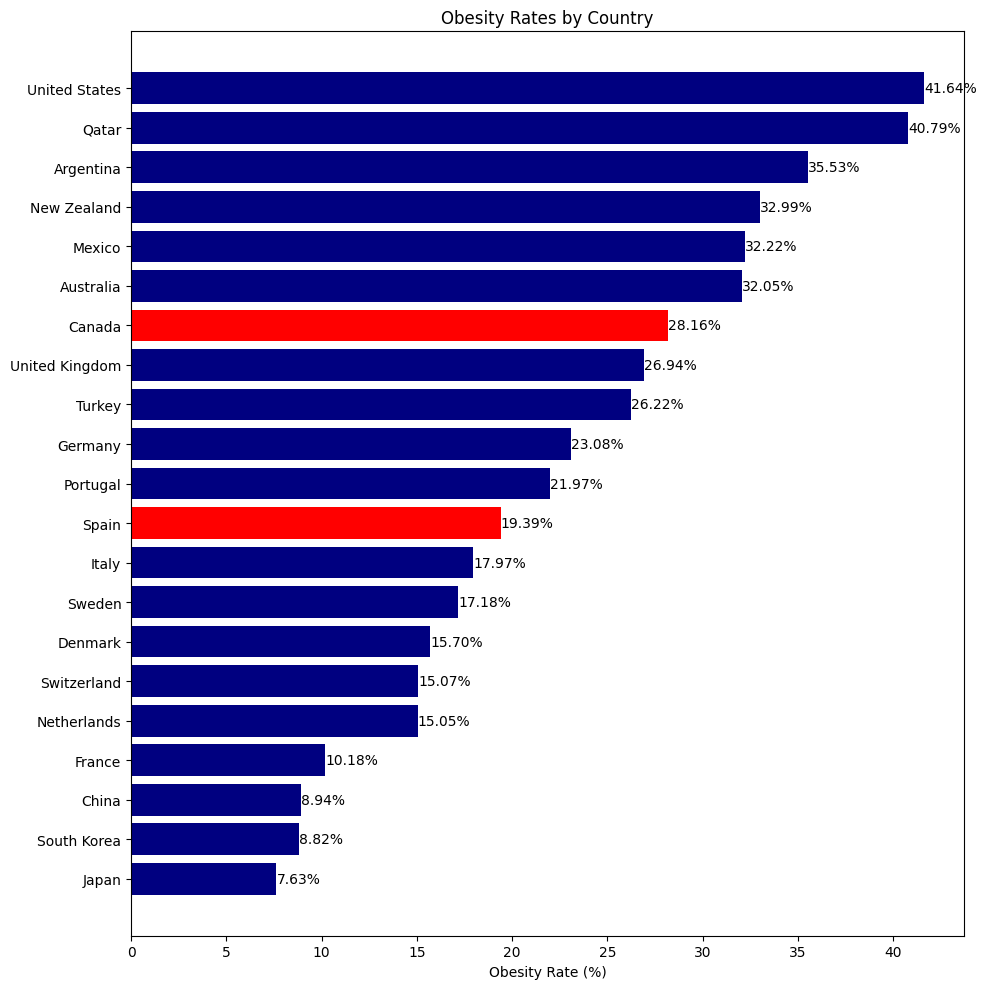

In [17]:
plt.figure(figsize=(10, 10)) 

colors = ['red' if country == "Spain" or country == "Canada" else 'navy' for country in sorted_countries]
bars = plt.barh(sorted_countries, sorted_obesity_rates, color=colors)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}%',
             va='center', ha='left')

plt.xlabel('Obesity Rate (%)')
plt.title('Obesity Rates by Country')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()